# Are the Doppler oscillations also explained by tracking signal lag?

Doppler residual oscillations of 50 mHz, or almost 1 mm/s given NEAR's X-band carrier, were obtained in the post-encounter Canberra track against the pre-encounter trajectory inferred from Goldstone data [1, 3].

The possibility that the same tracking signal lags caused these oscillations is correspondingly explored below by constructing the orbital elements from the Goldstone LOS state from Horizons to compute the post-encounter trajectory lagging signal and a least square fit post-encounter trajectory, to mimic JPL's procedure. 

In [1]:
from astropy import units as u
from astropy import constants as const
from astropy.time import Time

from poliastro.util import norm
from poliastro.frames import Planes
from poliastro.ephem import Ephem
from poliastro.bodies import Earth

from poliastro.twobody.orbit import Orbit
from poliastro.twobody.sampling import EpochsArray

from astropy.coordinates import solar_system_ephemeris

import numpy as np
import sys
sys.path.append('../')

from sim.stations import dss25, dss34
from sim.tracking import Tracking
from sim.util import describe_orbit, describe_state, describe_trajectory, find_swings

solar_system_ephemeris.set("de440")
goldstone_end = Tracking.NEAR_GOLDSTONE_END.value
canberra_start = Tracking.NEAR_CANBERRA_START.value
canberra_end = canberra_start + 30*u.day

In [2]:
sampling_interval = 3600
sample_offsets = np.arange(0, (canberra_end-canberra_start)/(1*u.s), sampling_interval)
flyby_epochs = canberra_start + (sample_offsets << u.s)
print("Start and end epochs:", flyby_epochs[0], flyby_epochs[-1], "[", flyby_epochs.size, "]")

Start and end epochs: 1998-01-23 09:53:55.600 1998-02-22 08:53:55.600 [ 720 ]


In [3]:
near_goldstone_ephem = Ephem.from_horizons("NEAR", goldstone_end, attractor=Earth, plane=Planes.EARTH_EQUATOR)
near_goldstone_end_rv = near_goldstone_ephem.rv(goldstone_end)
describe_state(near_goldstone_end_rv, dss25, goldstone_end)

near_goldstone_orbit = Orbit.from_vectors(Earth, near_goldstone_end_rv[0], near_goldstone_end_rv[1], goldstone_end)
describe_orbit(near_goldstone_orbit)


:AT: 1998-01-23 06:14:55.600
Geocentric distance: 37471.700215992445 km speed: 8.258344936971223 km / s
From Goldstone-25 : range  31576.174442159892 km , range rate  -7.684513660227914 km / s

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.97266698121356 deg
Eccentricity: 1.813357091534396
Semilatus rectum: 19437.250829758486 km
Semimajor axix: -8494.322039490264 km
Periapse radius: 6908.917068596319 km , altitude: 530.7804685963192 km


In [4]:
near_extended_ephem = near_goldstone_orbit.to_ephem(EpochsArray(flyby_epochs))
describe_trajectory(near_extended_ephem, dss34)


::TRAJECTORY::
Start and end ranges: 99245.7532096098 km 17847093.095720734 km
Start and end radial speeds: 7.3216176182785535 km / s 6.742051287016325 km / s
Closest: 73145.82143191747 km speed 7.5891622264313146 km / s  at  1998-01-23 09:53:55.600
Deflection: 0.457927625040083 deg


In [5]:
sim_meas = []

first_ref_rr = None
for e in flyby_epochs:
    rv = near_extended_ephem.rv(e)
    ref_r, ref_rr, ref_ra = dss34.range_rate_accel(rv, e)
    if first_ref_rr is None:
        first_ref_rr = ref_rr
    sim_meas.append([ref_r - first_ref_rr*ref_r/const.c])

#print(sim_meas)

In [6]:
print(sim_meas)

[[<Quantity 73144.03504363 km>], [<Quantity 99243.32940129 km>], [<Quantity 124950.10606088 km>], [<Quantity 150403.59536342 km>], [<Quantity 175702.03621052 km>], [<Quantity 200918.71045702 km>], [<Quantity 226109.55926743 km>], [<Quantity 251316.57686189 km>], [<Quantity 276569.33948814 km>], [<Quantity 301885.84104951 km>], [<Quantity 327273.22579454 km>], [<Quantity 352728.71060674 km>], [<Quantity 378240.82184945 km>], [<Quantity 403790.96919817 km>], [<Quantity 429355.31316428 km>], [<Quantity 454906.84106997 km>], [<Quantity 480417.5414147 km>], [<Quantity 505860.55493909 km>], [<Quantity 531212.17957678 km>], [<Quantity 556453.61391854 km>], [<Quantity 581572.33829513 km>], [<Quantity 606563.05292731 km>], [<Quantity 631428.11776984 km>], [<Quantity 656177.46766769 km>], [<Quantity 680828.00805639 km>], [<Quantity 705402.52917288 km>], [<Quantity 729928.20872645 km>], [<Quantity 754434.80199006 km>], [<Quantity 778952.64189609 km>], [<Quantity 803510.58760869 km>], [<Quantity 8

In [7]:
from sim.fitorbit import OrbitFitter
fitter = OrbitFitter(near_goldstone_orbit, [dss34], max_iter=100, var=0.001, debug=True, trace=True)

Range constraints:
a: -8485827.717450773 -8502816.361529753
ecc: 1.8115437344428615 1.8151704486259301
inc: 1.8825940624405615 1.8863630195225243
max iter: 100


In [8]:
from datetime import datetime 
start_time = datetime.now()
#print(start_time)

fitter.fit_range_data(flyby_epochs, sim_meas)
time_elapsed = datetime.now() - start_time
print(fitter.report())
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

describe_orbit(fitter.orbit)
describe_trajectory(fitter.ephem, dss34)

-1. 6774087.956496 {'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
0. 6774087.956496 {'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
1. 6774087.956496 {'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
2. 6774087.956496 {'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
3. 6774087.956496 {'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
4. 6774087.956496 {'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 'nu': -1.839424760

44. 3399574.798239 {'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 'nu': -1.8414052006977482, 'raan': 1.710982644130523, 'argp': 2.5854778721113867}
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 44
    # data points      = 720
    # variables        = 6
    chi-square         = 1.1557e+13
    reduced chi-square = 1.6186e+10
    Akaike info crit   = 16931.3309
    Bayesian info crit = 16958.8064
##  Warning: uncertainties could not be estimated:
    a:     at initial value
    ecc:   at initial value
    inc:   at initial value
[[Variables]]
    a:    -8494322.04 (init = -8494322)
    ecc:   1.81335709 (init = 1.813357)
    inc:   1.88447854 (init = 1.884479)
    nu:   -1.84140520 (init = -1.839425)
    raan:  1.71098264 (init = 1.540059)
    argp:  2.58547787 (init = 2.533258)
Time elapsed (hh:mm:ss.ms) 0:02:02.309157

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.97266698121356 deg
Eccentricity: 1.813357091534396
Se

The result indeed presents oscillations of similar magnitude, validating the signal lags hypothesis. The 3d visualization shows that the oscillations are entirely due to the lags and Earth rotation, as the trajectory itself is essentially linear and unchanged..

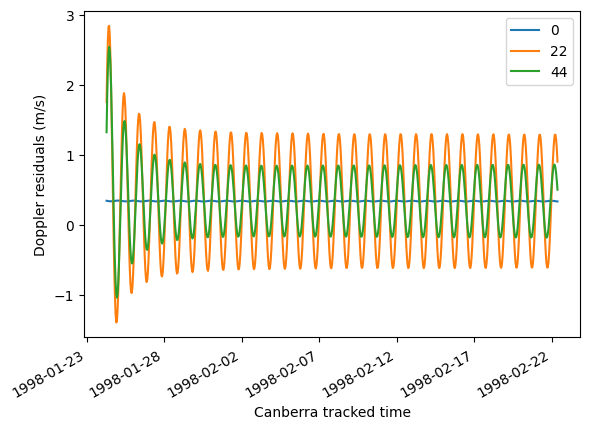

In [9]:
import matplotlib.pylab as plt
import matplotlib.dates as mdates
from astropy import visualization
with visualization.time_support():
    fig, ax = plt.subplots()
    plt.xlabel('Canberra tracked time')
    plt.ylabel('Doppler residuals (m/s)')
    for i, x in enumerate(fitter._resid):
        if i != 0 and i != 22 and i != 44:
            continue
        diff_range_residual = [(v-x[i-1])/sampling_interval for i, v in enumerate(x[1:])]
        ax.plot(flyby_epochs[21:], diff_range_residual[20:], label='{:d}'.format(i))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    ax.legend(loc="best")
    plt.gcf().autofmt_xdate()

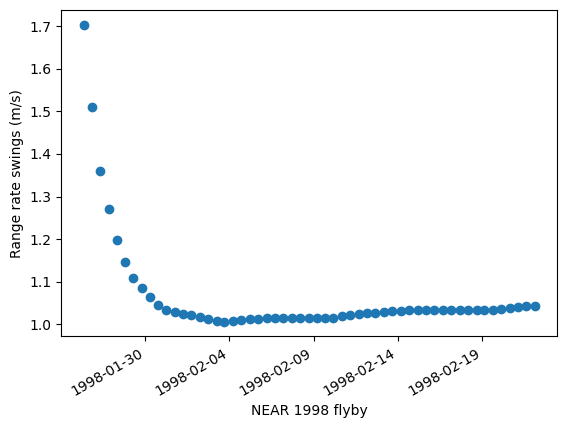

In [10]:
peak_epochs, peak_swings = find_swings(flyby_epochs[50:], diff_range_residual[50:])
with visualization.time_support():
    fig, ax = plt.subplots()
    plt.xlabel('NEAR 1998 flyby')
    plt.ylabel('Range rate swings (m/s)')
    plt.scatter(peak_epochs, peak_swings)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    plt.gcf().autofmt_xdate()